## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [3]:
from numba import jit, njit, vectorize, cuda, int32, float32
import math
import numpy as np

In [19]:

@vectorize([float32(int32)],target='parallel', fastmath=True)
def vec_log(x):
    return math.log(x)

@vectorize([float32(int32)],target='parallel', fastmath=True)
def vec_exp(x):
    c = math.exp(x)
    return c

A = [2,5,10,3,8]
print(vec_log(A))
print(vec_exp(A))

[0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
[7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

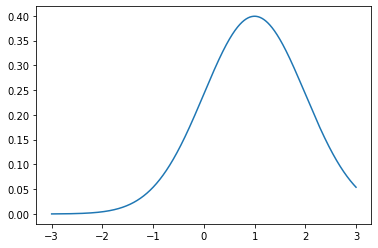

In [27]:
import numpy as np
import matplotlib.pyplot as plt
@jit
def gauss_prob(size):
    x = np.linspace(-3,3,size)
    y = (1/np.sqrt(2*np.pi))*np.exp(-((x-1)**2)/2)
    return y


plt.plot(np.linspace(-3,3,100000), gauss_prob(100000))
plt.show()

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

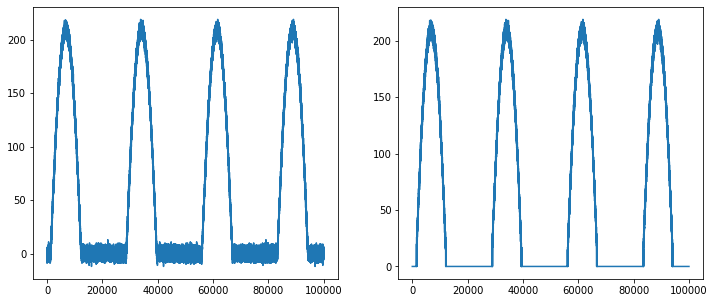

In [59]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)


#put your code here

def zeroSuppression1(data, threshold):
    data[data<threshold] = 0
    return data

def zeroSuppression2(data, threshold):
    for sample in data:
        if sample<threshold:
            sample = 0
    return data

@jit
def zeroSuppression3(data, threshold):
    data[data<threshold] = 0
    return data
@jit
def zeroSuppression4(data, threshold):
    for sample in data:
        if sample<threshold:
            sample = 0
    return data

@vectorize([float32(float32, int32)], target='parallel', fastmath=True)
def zeroSuppression5(data, threshold):
    if data<threshold:
        data = 0
    return data

# %timeit zeroSuppression1(data,15)
# %timeit zeroSuppression2(data,15)
# %timeit zeroSuppression3(data,15)
# %timeit zeroSuppression4(data,15)
# # data_l = list(data)
# # %timeit zeroSuppression4(data_l,15)
# %timeit zeroSuppression5(data,15)

threshold = 15
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(data)
ax[1].plot(zeroSuppression3(data, threshold))


## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [55]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

@vectorize
def vec_tanh(arg):
    return math.tanh(arg)
@jit
def sigmoidKernel(x,y,alpha,c):
    arg = np.dot(alpha*x.T,y)+c 
    return vec_tanh(arg)

k = sigmoidKernel(X,Y,1,4)
print(k)

[[0.9997363  0.99979335 0.99985248]
 [0.99968383 0.99976627 0.99980308]
 [0.99975286 0.99986086 0.99990138]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [8]:
@cuda.jit
def kernel_3d(matrix_3d):
    x, y, z = cuda.grid(3)
    if x < matrix_3d.shape[0] and y < matrix_3d.shape[1] and z < matrix_3d.shape[2]:
        matrix_3d[x, y, z] = math.cos(matrix_3d[x, y, z])

data = np.random.random((256, 256, 256))
        
threadsperblock = (16, 8, 4)
blockspergrid_x = int(np.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(np.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(np.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

kernel_3d[blockspergrid, threadsperblock](data)

print(data.shape)
print(data)

(256, 256, 256)
[[[0.99708639 0.99639024 0.99988744 ... 0.99349903 0.99892961 0.69250389]
  [0.99712261 0.75159563 0.73743124 ... 0.86017775 0.64552194 0.68267836]
  [0.99565423 0.97464798 0.8130088  ... 0.69139245 0.98933632 0.99736411]
  ...
  [0.8931618  0.97748012 0.91368156 ... 0.95940084 0.75873138 0.55793886]
  [0.99260653 0.99640726 0.77897123 ... 0.99995854 0.80698691 0.99693775]
  [0.69592333 0.99559348 0.86470913 ... 0.99939095 0.57848684 0.58722153]]

 [[0.99109479 0.96238814 0.73685255 ... 0.83610753 0.96360205 0.94515342]
  [0.9412905  0.83823371 0.92370576 ... 0.60071485 0.60368447 0.77582815]
  [0.84799805 0.60049061 0.67183463 ... 0.93028301 0.56163266 0.58538937]
  ...
  [0.80037556 0.96264611 0.9191575  ... 0.92002103 0.96562483 0.98321225]
  [0.86544209 0.76579069 0.97623835 ... 0.99352197 0.64487568 0.64823124]
  [0.9922658  0.96403053 0.64566024 ... 0.81346819 0.99098757 0.92009611]]

 [[0.87586475 0.94330125 0.84845364 ... 0.70492827 0.69741116 0.99541207]
  [0.8

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [9]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(22, size=(24,12))
B = np.random.randint(22, size=(24,12))

# Configure the blocks
threadsperblock = (16, 16)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

C = np.zeros((24,12))
matmul[blockspergrid, threadsperblock](A, B, C)

print(C)

[[1285. 1370. 1264. 1544.  769. 1675. 1121. 1353. 1405. 1529. 1447. 2046.]
 [1465. 1537. 1626. 1625.  762. 1570. 1437. 1359. 1543. 1795. 1892. 1894.]
 [1024. 1081. 1112. 1519.  590. 1124. 1035. 1268. 1124. 1307. 1373. 1613.]
 [1528. 1269. 1276. 1425.  689. 1319. 1221. 1047.  796. 1656. 1439. 1702.]
 [ 736.  807.  789.  853.  420.  983.  902.  727.  581. 1044. 1016. 1115.]
 [1274. 1295. 1272. 1287.  829. 1430. 1300. 1169. 1206. 1513. 1078. 1990.]
 [1506. 1290. 1247. 1472.  700. 1040. 1072. 1024.  943. 1685. 1387. 1532.]
 [1364. 1260. 1041. 1213.  720. 1565. 1045. 1085.  845. 1551. 1149. 1699.]
 [1407. 1102. 1300. 1607.  733. 1509. 1214. 1079. 1192. 1651. 1291. 1793.]
 [1236. 1215. 1379. 1585.  545. 1444. 1405.  898. 1185. 1541. 1767. 1653.]
 [1741. 1672. 1625. 1635.  802. 1799. 1436. 1230. 1491. 1883. 1910. 2110.]
 [1571. 1478. 1468. 1740.  723. 1507. 1098. 1392.  941. 1630. 1567. 1843.]
 [1613. 1718. 1350. 1484.  828. 1644. 1441. 1233. 1224. 1792. 1665. 1941.]
 [1348. 1318.  913.  906.